# Workflow

In [12]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np

import time
from scipy.stats import loguniform, randint
from scipy.stats import uniform, randint

import warnings
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.model_selection import RFECV
import xgboost as xgb

In [13]:
# !pip install --index-url https://pypi.nvidia.com --extra-index-url https://pypi.org/simple cudf-cu12




In [14]:
# Set up directory
os.chdir("/home/siti/Downloads/New Modelling")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')

In [15]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [16]:
results_folder = Path("XGBoost_folder/Version 2/Model 2")
results_folder.mkdir(parents=True, exist_ok=True) 

In [17]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [18]:
data = df.copy()

# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [19]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [20]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [21]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Step 3: One-Hot Encoding 

In [22]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]


# Step 4: Ordinal Encoding

In [23]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_Arrive_HourOfDay': ['01-04','05-08','09-12','13-16','17-20','21-24'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High']
}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Undersampling the majority class

In [24]:
# Initialize the random undersampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the data with the undersampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Counts of each class
print(y_train_resampled.value_counts())

# Proportions of each class
print(y_train_resampled.value_counts(normalize=True) * 100)


0    545444
1    545444
Name: LOS_Category, dtype: int64
0    50.0
1    50.0
Name: LOS_Category, dtype: float64


# Step 6: Standardize Dataset

In [25]:
# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [26]:
print(X_train_scaled.shape)
print(y_train_resampled.shape)


(1090888, 21)
(1090888,)


# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).



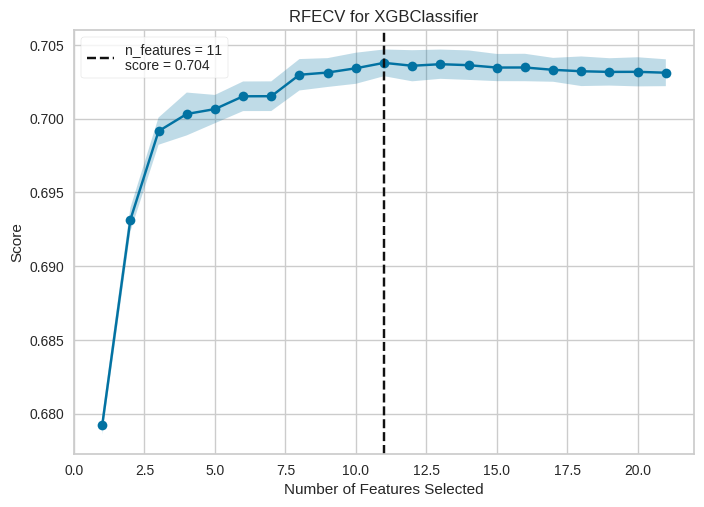

RFECV took 653.73 seconds.


In [28]:
# Record the start time
start_time = time.time()

# Initialize the XGBoost estimator with GPU acceleration
estimator = xgb.XGBClassifier(
    objective='binary:logistic',  
    booster='gbtree',
    tree_method='gpu_hist',  
    random_state=42
)

# Use RFECV from Yellowbrick with the settings
visualizer = RFECV(estimator, step=1, cv=5,scoring ='roc_auc')


visualizer.fit(X_train_scaled, y_train_resampled)

# Set the title, x-label, and y-label before saving the figure
plt.title("RFECV - Feature Selection with XGBoost on GPU")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score")
plt.savefig(results_folder / "RFECV_XGB_GPU_V02.png", dpi=300)

# Show the visualizer
visualizer.show()

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")


In [29]:
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)


Selected Features: ['Age_Band', 'ICD10_Chapter_Code_Other', 'ICD10_Chapter_Code_X', 'ICD10_Chapter_Code_XI', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_300', 'TFC_420', 'TFC_OTHER']


In [30]:


# Extract columns from the scaled and resampled training set using the list of selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]


# Step 8: Hyperparameter Tuning with Randomized Search CV

After feature selection, use RandomizedSearchCV for hyperparameter tuning on the training set. The cross-validation within RandomizedSearchCV uses multiple train-validation splits of the training data.



In [31]:
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'tree_method': ['gpu_hist'],  # Use GPU accelerated algorithm
    'predictor': ['gpu_predictor']
}
# Record the start time
start_time = time.time()

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_jobs=-1)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Number of random combinations to sample (n_iter) is set to 50 as a baseline.
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=50, 
                                   cv=stratified_kfold, scoring='roc_auc', n_jobs=7, random_state=42, verbose = True)

random_search.fit(X_train_selected_scaled, y_train_resampled)

# Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df.to_csv(results_folder /'cv_results.csv', index=False)

# Print results
print("Best parameters for XGBoost Tree:", random_search.best_params_)
print("Best ROC-AUC score for XGBoost Tree:", random_search.best_score_)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for XGBoost Tree took {duration:.2f} seconds.")

# Save the model
dump(random_search, results_folder /'random_search_model.joblib')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBoost Tree: {'tree_method': 'gpu_hist', 'subsample': 0.7, 'predictor': 'gpu_predictor', 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1}
Best ROC-AUC score for XGBoost Tree: 0.7706367032254284
Hyperparameter tuning for XGBoost Tree took 659.15 seconds.


['XGBoost_folder/Version 2/Model 2/random_search_model.joblib']

<!-- ## XGBoost with Decision Tree -->

# Step 9: Train the whole dataset with best hyperparameters


In [32]:
# Extracting selected features for validation, and test sets:

X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]

In [33]:
# Define the best hyperparameters
best_params = random_search.best_params_

# Record the start time
start_time = time.time()

# Train a DT model using the best hyperparameters on the training set
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for XGBoost took {duration:.2f} seconds.")

Training for XGBoost took 4.88 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [34]:
# Record the start time
start_time = time.time()



y_val_pred = best_model.predict(X_val_selected_scaled)
y_val_prob = best_model.predict_proba(X_val_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the validation set using multiple metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_prob)  # Note: roc_auc_score uses probability estimates
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

# Print the metrics
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("ROC-AUC:", val_roc_auc)
print("F1 Score:", val_f1)
print("Precision:", val_precision)
print("Recall:", val_recall)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Validating for XGBoost took {duration:.2f} seconds.")

Validation Metrics:
Accuracy: 0.6051452046497762
ROC-AUC: 0.7707222171928325
F1 Score: 0.7376436947665899
Precision: 0.9802338007188887
Recall: 0.5913061386456905
Validating for XGBoost took 2.54 seconds.


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [35]:

# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Record the start time
start_time = time.time()

# Train the final model on the combined set
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for XGBoost took {duration:.2f} seconds.")

Training for XGBoost took 10.89 seconds.


In [36]:
# Save the model
dump(final_model, results_folder / 'final_model_XGBoost.joblib')

['XGBoost_folder/Version 2/Model 2/final_model_XGBoost.joblib']

# Step 12: Predict on test set

In [37]:


# Predict on the test set
y_test_pred = final_model.predict(X_test_selected_scaled)
y_test_prob = final_model.predict_proba(X_test_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the test set using multiple metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the metrics
print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("ROC-AUC:", test_roc_auc)
print("F1 Score:", test_f1)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("Confusion Matrix:")
print(test_conf_matrix)

Test Metrics:
Accuracy: 0.932534311359705
ROC-AUC: 0.7715990171047964
F1 Score: 0.9649559223693669
Precision: 0.9416413312501892
Recall: 0.9894543408460642
Confusion Matrix:
[[   7030  109855]
 [  18892 1772556]]


# Step 13: Save the metrics

In [38]:
# Save all metrics in a csv file

metrics = {
    "ROC-AUC Test": test_roc_auc ,
    "Accuracy": test_accuracy,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Confusion Matrix": test_conf_matrix
}

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model2_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: XGBoost_folder/Version 2/Model 2/Model2_Performance_metrics.csv


# ROC-AUC Curve

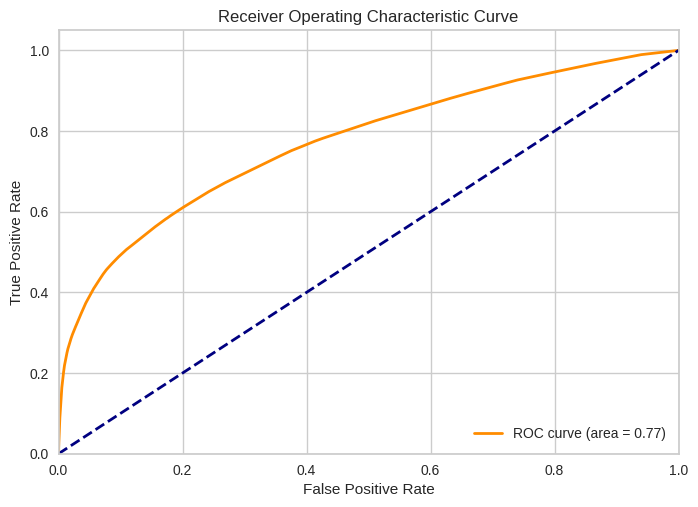

In [39]:
# y_test_prob contains the predicted probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(results_folder / "roc_auc.png", dpi=300)
plt.show()


# Precision-Recall Curve

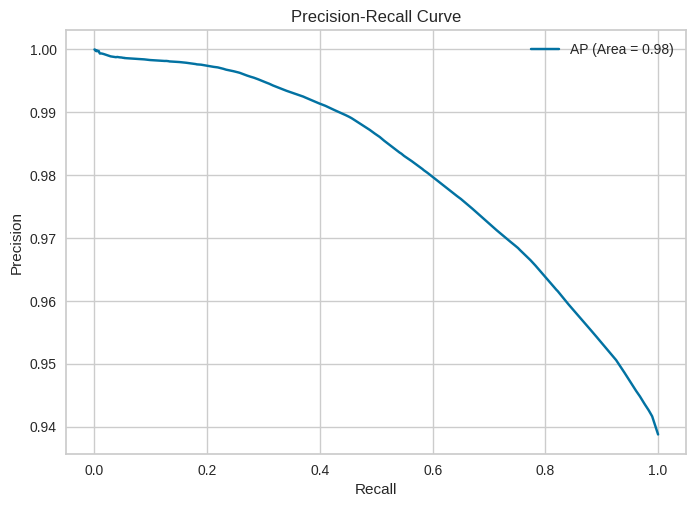

In [40]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure()
plt.plot(recall, precision, label='AP (Area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "precision_recall.png", dpi=300)
plt.show()

# Calculate Error

In [41]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.216
Validation Error: 0.068
Test Error: 0.067


# Feature Importance

Need to use Scikit-Learn package to get feature importances

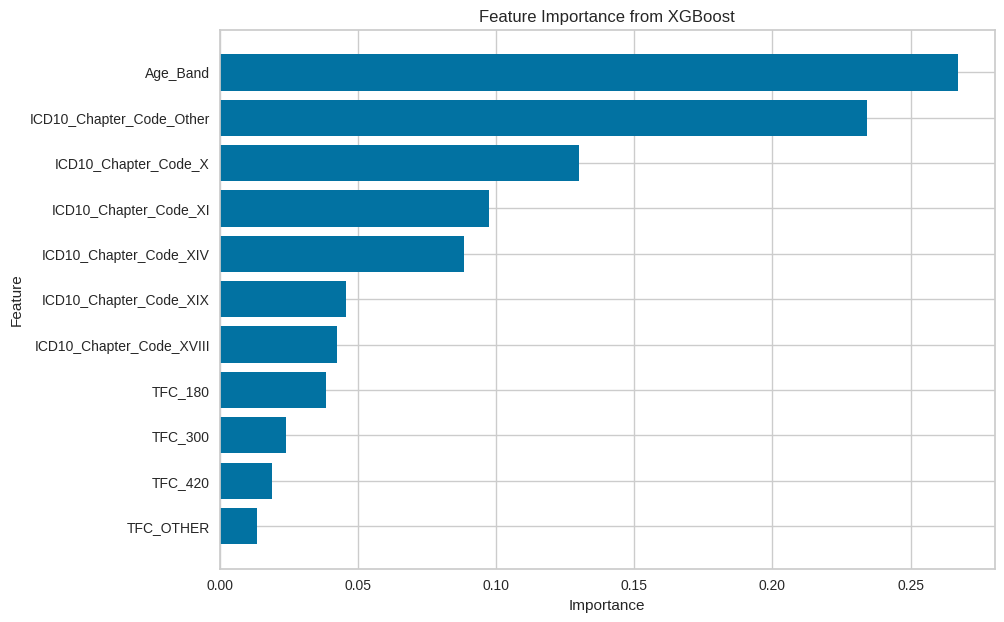

In [42]:
# Retrieve Feature Importance
importances = final_model.feature_importances_

# Match Feature Importance to Feature Names:
feature_names = [X_train.columns[i] for i in selected_feature_indices]

# Sort Features by Importance:
sorted_idx = np.argsort(importances)[::-1]

# Plot

plt.figure(figsize=(10, 7))
plt.barh(feature_names, importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature_Importance.png", dpi=300)
plt.show()


In [43]:
# Create a DataFrame to hold feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on the importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save the DataFrame to a CSV file
feature_importance_df.to_csv(results_folder / 'Feature_Importance.csv', index=False)